# BioRealistic-SRM-STDP-TensorFlow

This notebook implements a bio-realistic neuron model using TensorFlow, based on the Leaky Integrate-and-Fire (LIF) response model and Spike-Timing-Dependent Plasticity (STDP). The model simulates an neuron with detailed state variables and synaptic dynamics, capable of processing online input sequences.

#### Theoretical Background

**Leaky Integrate-and-Fire Model (LIF)**:
- The LIF model is a simplified representation of neuronal activity that captures essential features of spiking neurons. It integrates incoming signals, accounting for the decay of potential over time (leakage), and generates an output spike when the membrane potential exceeds a threshold.

**Spike-Timing-Dependent Plasticity (STDP)**:
- STDP is a biological learning rule observed in the brain, where the timing of spikes from pre- and post-synaptic neurons influences the strength of their connection. If a pre-synaptic neuron fires shortly before a post-synaptic neuron, the connection is strengthened (potentiation). Conversely, if the pre-synaptic neuron fires shortly after the post-synaptic neuron, the connection is weakened (depression).

#### Features

- **Neuron Dynamics**: Incorporates membrane and synaptic potentials, with parameters such as membrane time constant, synaptic time constant, and thresholds.
- **Weight Updates**: Follows STDP rules, adjusting synaptic weights based on spike timings.
- **Input Sequences**: Handles online input sequences generated using a custom Poisson process, with the ability to embed patterns.
- **Visualization Tools**: Provides comprehensive visualizations of neuronal potential evolution, input sequences, and weight adaptations.


In [ ]:
# Libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


### Generating Input Sequence Function

This function generates input sequences based on a Poisson point process, a common method for modeling random events that occur independently over time.

#### Theoretical Background

**Poisson Point Process**:
- A Poisson point process is a stochastic process that models the occurrence of events happening at a constant average rate, independently of the time since the last event. In the context of neural modeling, it is often used to simulate spike trains, where the timing of each spike is random but follows a known average rate.

#### Function Description

**`my_poisson(p_lambda, last_spike, rate, rate_derivative, rand_1, rand_2)`**:
- This function generates a spike train based on the specified parameters.
- **Parameters**:
  - `p_lambda`: The base rate parameter of the Poisson process.
  - `last_spike`: Tracks the time steps since the last spike.
  - `rate`: The current firing rate of the neuron.
  - `rate_derivative`: The rate of change of the firing rate.
  - `rand_1`, `rand_2`: Random values used to introduce variability in the spike generation.
- **Output**:
  - Returns a tuple `(spike, last_spike, rate, rate_derivative)`, where `spike` is 1 if a spike occurs, and 0 otherwise.

The function ensures that the generated spike train follows the statistical properties of a Poisson process, with variability introduced by the random values and the rate dynamics.


In [ ]:
# Custom Poisson function for input sequence generation
def my_poisson(p_lambda, last_spike, rate, rate_derivative, rand_1, rand_2):
    spike = 0
    rate_derivative += 16 * p_lambda * (rand_1 - 0.5)
    rate_derivative = np.clip(rate_derivative, -40 * p_lambda, 40 * p_lambda)
    rate += rate_derivative / 1000
    rate = np.clip(rate, 0, 2 * p_lambda)

    if rate / 1000 > rand_2 or last_spike >= 49:
        spike = 1
        last_spike = 0
    else:
        last_spike += 1

    return spike, last_spike, rate, rate_derivative


### Bio-Realistic Neuron Model

This bio-realistic neuron model is based on the Leaky Integrate-and-Fire (LIF) response model and Spike-Timing-Dependent Plasticity (STDP).

#### Theoretical Background

**Leaky Integrate-and-Fire Model (LIF)**:
- The LIF model describes how a neuron's membrane potential evolves over time in response to incoming stimuli. The membrane potential $u_{m}$ integrates the input signals and decays exponentially due to leakage $u_{s}$.

**Key Equations**:
1. **Membrane Potential Update**:
$$ u_{m}(t+1) = u_{m}(t) \cdot exp(-\frac{\Delta t}{\tau_{m}}) + K \cdot \sum_{j} w_{j} \cdot x_{j}(t) $$
where:
  - $ \tau_{m} $ is the membrane time constant.
  - $ K $ is a scaling constant.
  - $ w_{i} $ are the synaptic weights.
  - $ x_{i}(t) $ are the input signals.

2. **Synaptic Potential Update**:
$$ u_{s}(t+1) = u_{s}(t) \cdot exp(-\frac{\Delta t}{\tau_{s}}) - K \cdot \sum_{i} w_{i} \cdot x_{i}(t) $$
where $ \tau_{s} $ is the synaptic time constant.

3. **Total Potential**:
$$ u(t+1) = u_{m}(t+1) + u_{s}(t+1) $$

4. **Spike Generation**:
If $ u(t) > \theta $ and $ \frac{d}{dt}u(t) > 0 $, then the potential updates as $u_{m}(t) = u^{reset}_{m}$, $u_{s}(t) = u^{reset}_{s}$ and the neuron fires.

**Spike-Timing-Dependent Plasticity (STDP)**:
- STDP is a mechanism where the synaptic weights are adjusted based on the relative timing of pre- and post-synaptic spikes.

**Key Equations**:
1. **Potentization**:
if $ t_{j} <= t_{i} $ then:
$$ dw^{p}_{i} = A_{p}exp(\frac{t_{j} - t_{i}}{\tau_{p}}) $$

2. **Depression**:
if $ t_{j} > t_{i} $ then:
$$ dw^{d}_{i} = A_{d}exp(\frac{t_{i} - t_{j}}{\tau_{d}}) $$

3. **Weights Updating**
$$ w_{i}(t+1) = w_{i}(t) + dw^{p}_{i}(t) - dw^{d}_{i}(t) $$
where:
  - $ dw^{p} $ is the potentization gradient.
  - $ dw^{d} $ is the depression gradient.
  - $ A_{p} $ is the potentization amplitude.
  - $ A_{d} $ is the depression amplitude.
  - $ \tau_{p} $ is the potentization time constant.
  - $ \tau_{d} $ is the depression time constant.
  - $ t_{j} $ is the time of the last presynaptic input spike.
  - $ t_{i}(t) $ is the time of the last postsynaptic output spike.


In [ ]:
# Generate input sequence with a pattern
def generate_input_sequence(input_size, total_time, pattern_size, pattern_length=50, pattern_interval=200):
    p_lambda = 45
    last_spike, rate, rate_derivative = 0, 0, 0
    input_sequence = np.zeros((input_size, total_time + pattern_interval))
    pattern_sequence = np.zeros((input_size, total_time+pattern_interval))

    spike = np.zeros(input_size)
    last_spike = np.zeros(input_size)
    rate = np.zeros(input_size)
    rate_derivative = np.zeros(input_size)

    for t in range(total_time + pattern_interval):
        for i in range(input_size):
            rand_1, rand_2 = np.random.uniform(), np.random.uniform()
            spike[i], last_spike[i], rate[i], rate_derivative[i] = my_poisson(p_lambda, last_spike[i], rate[i], rate_derivative[i], rand_1, rand_2)
            input_sequence[i, t] = spike[i]

    # Insert pattern at regular intervals
    pattern = input_sequence[:pattern_size, -pattern_length:]
    for t in range(0, total_time + pattern_interval, pattern_interval):
        _ = t + np.random.normal(0,pattern_length/4)
        _ = np.clip(_, 0, total_time)
        input_sequence[:input_size // 2, t:t + pattern_length] = pattern
        pattern_sequence[:input_size // 2, t:t + pattern_length] = pattern

    return input_sequence[:, pattern_interval:], pattern_sequence[:, pattern_interval:], pattern

In [ ]:
# Define bio-realistic neuron model
class BioRealisticNeuron(tf.keras.layers.Layer):
    def __init__(self, input_size, **kwargs):
        super(BioRealisticNeuron, self).__init__(**kwargs)
        self.input_size = input_size
        self.W = self.add_weight(shape=(input_size,), initializer="ones", trainable=True)
        self.W.assign(self.W * 0.465)
        self.u_m = tf.Variable(0.0)
        self.u_s = tf.Variable(0.0)
        self.u = tf.Variable(0.0)
        self.dW_p = tf.Variable(tf.zeros(input_size))
        self.dW_d = tf.Variable(tf.zeros(input_size))
        self.A_p = 0.03125
        self.A_d = 0.87 * self.A_p
        self.t_m = 10.0
        self.t_s = 2.5
        self.t_p = 16.8
        self.t_d = 33.7
        self.K = tf.pow( self.t_m / self.t_s, self.t_m / ( self.t_m - self.t_s ) ) * self.t_s / ( self.t_m - self.t_s )
        self.th = 0.25 * self.input_size

    def call(self, inputs):
        # Spike Response Model
        self.u_m = self.u_m * tf.exp(-1/self.t_m) + self.K * tf.reduce_sum(self.W * inputs)
        self.u_s = self.u_s * tf.exp(-1/self.t_s) - self.K * tf.reduce_sum(self.W * inputs)
        u_new = self.u_m + self.u_s

        output = 0.0
        if((u_new > self.th) and (u_new > self.u)):
            self.u_m = - 2 * self.th
            self.u_s = 4 * self.th
            output = 1.0
        self.u.assign(self.u_m + self.u_s)

        # Spike-Timing Dependent Plasticity
        stdp = True
        if(stdp):
          if( output == 1 ):
              self.W.assign_add(self.dW_p)
              self.W.assign(tf.clip_by_value(self.W, 0, 1))
              self.dW_p.assign(tf.zeros_like(self.dW_p))
              self.dW_d.assign(tf.fill(self.dW_d.shape, self.A_d))

          self.dW_p.assign(self.dW_p * tf.exp(-1/self.t_p))
          self.dW_d.assign(self.dW_d * tf.exp(-1/self.t_d))

          self.dW_p.assign(tf.fill(self.dW_p.shape, self.A_p)*tf.cast(inputs > 0, tf.float32) + self.dW_p*tf.cast(inputs <= 0, tf.float32))
          self.W.assign_add(-self.dW_d*tf.cast(inputs > 0, tf.float32))
          self.W.assign(tf.clip_by_value(self.W, 0, 1))
          self.dW_d.assign(tf.zeros_like(self.dW_d)*tf.cast(inputs > 0, tf.float32) + self.dW_d*tf.cast(inputs <= 0, tf.float32))

        return output, self.u, self.W

In [ ]:
# Create model
class BioRealisticModel(tf.keras.Model):
    def __init__(self, input_size, **kwargs):
        super(BioRealisticModel, self).__init__(**kwargs)
        self.neuron = BioRealisticNeuron(input_size)

    def call(self, inputs):
        outputs = []
        u_values = []
        w_values = []
        for t in range(inputs.shape[1]):
            output, u, w = self.neuron(inputs[:, t])
            outputs.append(output)
            u_values.append(u.numpy())
            w_values.append(w.numpy())
        return outputs, u_values, w_values

In [ ]:
# Set hyperparameters
input_size = 2000
pattern_size = 1000
total_time = 30000

In [ ]:
# Generate input sequence
input_sequence, pattern_sequence, pattern = generate_input_sequence(input_size, total_time, pattern_size)

In [ ]:
# Initialize and run model
model = BioRealisticModel(input_size)
outputs, u_values, w_values = model(tf.convert_to_tensor(input_sequence, dtype=tf.float32))


### Visualization Section

The visualization tools in this cell are designed to provide an insightful analysis of the neuron model's behavior over time. The visualizations include plots that depict the evolution of neuronal potentials, the input sequences, and the synaptic weights in relation to embedded patterns.

#### Visualization Components

1. **Input Sequence and Potential Evolution**:
   - This part of the visualization shows two subplots:
     - **Input Sequence**: Displays the sequence of inputs over time using a scatter plot to highlight the presence of spikes.
     - **Potential Evolution**: Illustrates the changes in the membrane potential of a neuron over time, providing insight into its dynamic behavior.

2. **Pattern and Weights**:
   - This part includes two vertically stacked subplots:
     - **Extended Pattern**: Shows the pattern extended with zeros, providing a visual reference for the repeated input pattern.
     - **Weights**: Displays the synaptic weights as bars adjacent to the extended pattern, highlighting how the weights correspond to the input pattern.


These visualizations provide a comprehensive view of how the neuron model processes input sequences and adapts synaptic weights based on the STDP learning rule.


<ipython-input-12-d6b21e1ea833>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


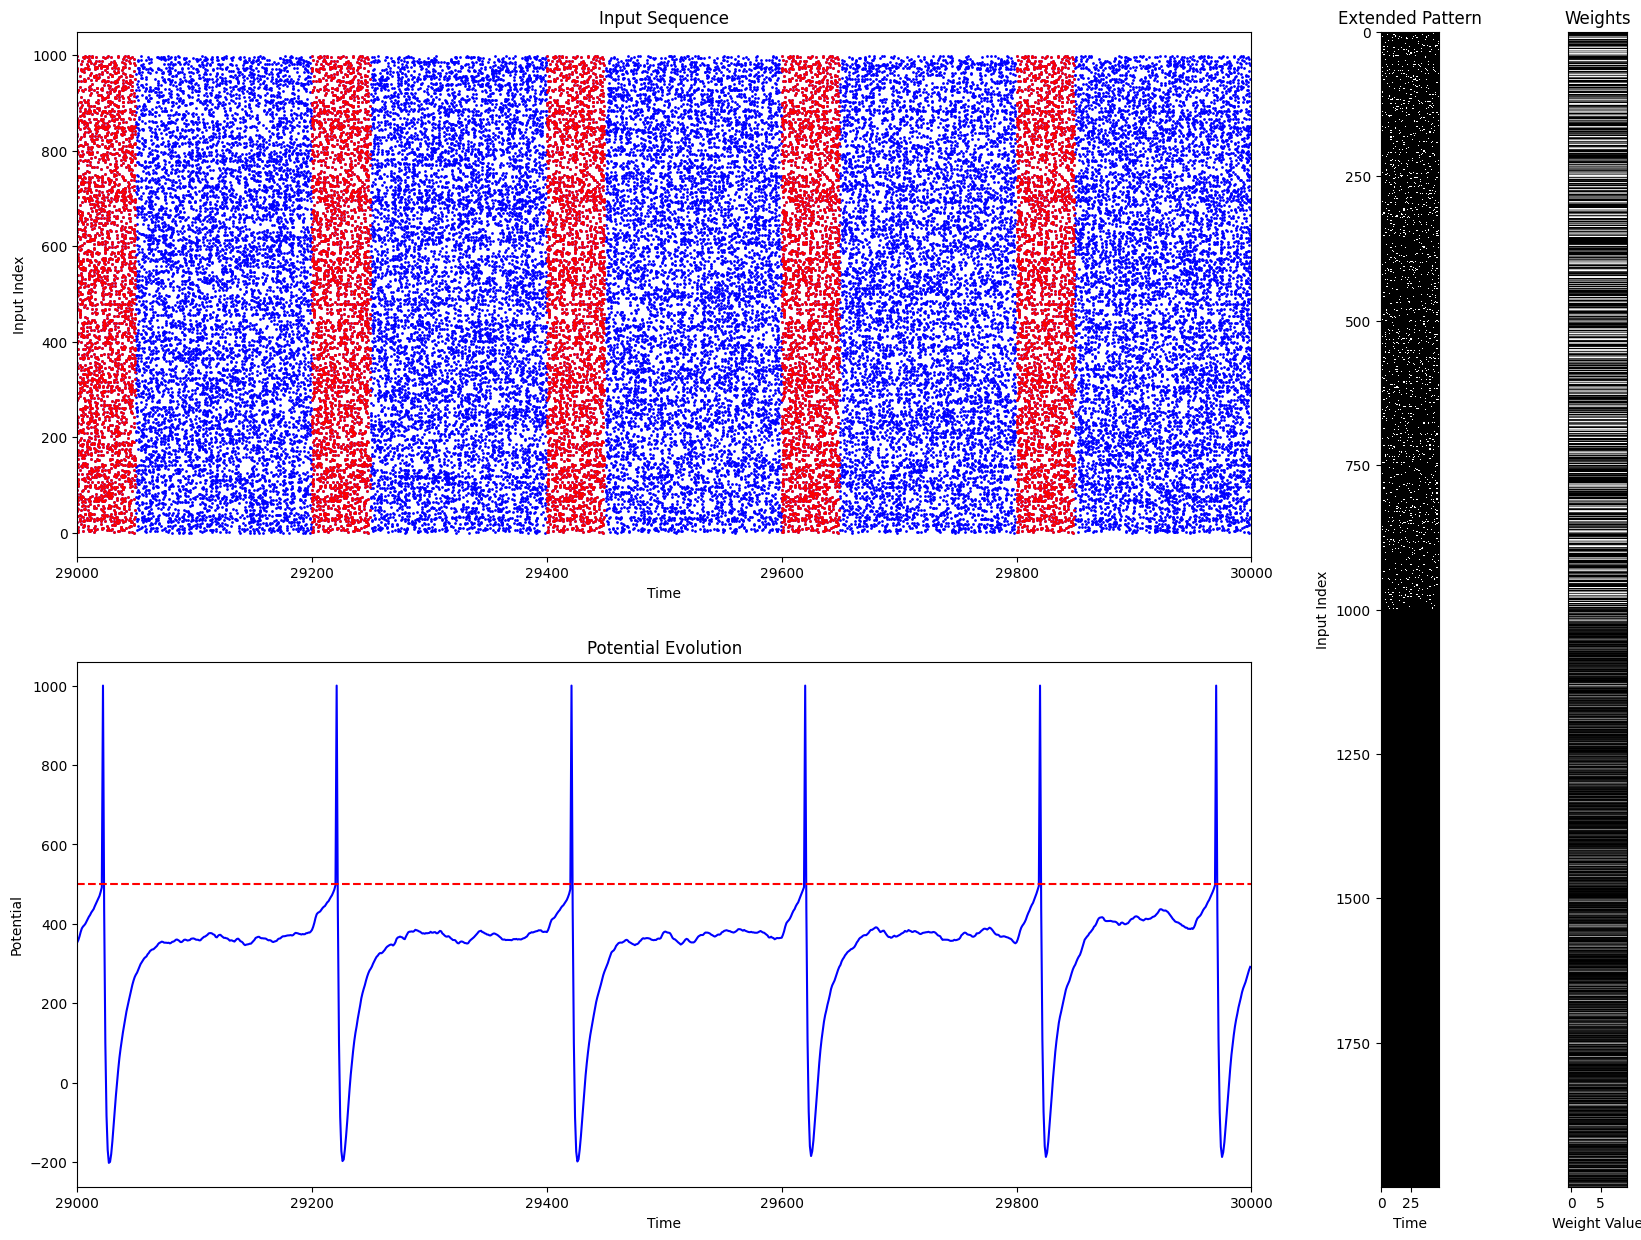

In [ ]:
# Get final weights
final_weights = w_values[-1]

# Extend the pattern with zeros to match the input size
pattern_extended = np.zeros((input_size, pattern.shape[1]))
pattern_extended[:pattern_size, :] = pattern

# Visualization
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 3, width_ratios=[1, 0.05, 0.05], height_ratios=[1, 1], wspace=0.3, hspace=0.2)

# Input sequence subplot
ax_input_sequence = fig.add_subplot(gs[0, 0])
ax_input_sequence.set_title('Input Sequence')
input_times = np.arange(total_time - 1000, total_time)
input_indices, input_times_extended = np.where(input_sequence[:pattern_size, -1000:] == 1)
ax_input_sequence.scatter(input_times_extended + total_time - 1000, input_indices, s=1, color='blue')

pattern_times = np.arange(total_time - 1000, total_time)
pattern_indices, pattern_times_extended = np.where(pattern_sequence[:pattern_size, -1000:] == 1)
ax_input_sequence.scatter(pattern_times_extended + total_time - 1000, pattern_indices, s=1, color='red')

ax_input_sequence.set_xlim(total_time - 1000, total_time)
ax_input_sequence.set_ylabel('Input Index')
ax_input_sequence.set_xlabel('Time')

# Potential evolution subplot
ax_potential_evolution = fig.add_subplot(gs[1, 0])
ax_potential_evolution.set_title('Potential Evolution')
ax_potential_evolution.plot(np.arange(total_time - 1000, total_time), u_values[-1000:], color='blue')
ax_potential_evolution.axhline(model.neuron.th, color='red', ls = '--')
ax_potential_evolution.set_xlim(total_time - 1000, total_time)
ax_potential_evolution.set_ylabel('Potential')
ax_potential_evolution.set_xlabel('Time')

# Extended pattern subplot
ax_extended_pattern = fig.add_subplot(gs[:, 1])
ax_extended_pattern.set_title('Extended Pattern')
cax1 = ax_extended_pattern.imshow(pattern_extended, aspect='auto', cmap='gray', interpolation='nearest')
ax_extended_pattern.set_ylabel('Input Index')
ax_extended_pattern.set_xlabel('Time')

# Weights subplot
ax_weights = fig.add_subplot(gs[:, 2])
ax_weights.set_title('Weights')
weights_image = np.tile(final_weights[:, np.newaxis], (1, 10))  # Expand weights for better visualization
cax2 = ax_weights.imshow(weights_image, aspect='auto', cmap='gray', interpolation='nearest')
ax_weights.set_xlabel('Weight Value')
ax_weights.set_yticks([])  # Hide y-axis labels as they correspond to input indices

plt.tight_layout()
plt.show()